In [2]:
import os
import glob

# Found file corresponding to this W&B run with: `grep "3pzwny4n" outputs/*/args.json`
model_folder = '../outputs/crepe-20211129-122548'

model_paths = glob.glob(os.path.join(model_folder, '*'))

import sys
sys.path.append('/home/jxm3/research/transcription/contrastive-pitch-detection')

from models.bytedance import Bytedance_Regress_pedal_Notes
from models.contrastive import ContrastiveModel

min_midi = 21
max_midi = 108
def get_model():
    num_output_nodes = 256 # contrastive embedding dim
    out_activation = None
    
    model = Bytedance_Regress_pedal_Notes(
        num_output_nodes, out_activation, tiny=False
    )
    
    return ContrastiveModel(model, min_midi, max_midi, num_output_nodes)

import glob
import natsort
import os

model_paths = glob.glob(os.path.join(model_folder, '*'))

model_path = natsort.natsorted(model_paths)[-2]
print('loaded model from:', model_path)

import torch
model = get_model()
model.load_state_dict(torch.load(model_path)['model'])

loaded model from: ../outputs/crepe-20211129-122548/84_epochs.pth


<All keys matched successfully>

In [7]:
import collections
import numpy as np
from dataloader import MusicDataLoader

sample_rate = 16_000
frame_length = 16_000

tracks = MusicDataLoader(sample_rate, frame_length, 
    # datasets=['nsynth_train'],
    datasets=['nsynth_keyboard_train'],
    # datasets=['nsynth_keyboard_valid'],
    batch_by_track=False, val_split=0.0
).load()

notes_by_midi = collections.defaultdict(list)
for idx in range(len(tracks)):
    track = tracks[idx]
    instrument_str, midi, velocity = track.name.split('-')
    midi, velocity = int(midi), int(velocity)
    notes_by_midi[midi].append(track)

midis = np.array([m for m in notes_by_midi.keys() if min_midi <= m <= max_midi])
midis = np.sort(midis)
midi_probs = np.array([len(notes_by_midi[m]) for m in midis])
midi_probs = midi_probs.astype(float)
midi_probs /= midi_probs.sum() # Normalize probabilities

--> MusicDataLoader loading dataset nsynth_keyboard_train


Resampling tracks: 100%|██████████| 51821/51821 [00:00<00:00, 1225449.23it/s]


# I want to compute the similarities for a single note and its similar notes and chords.

In [83]:
import itertools
def note_and_neighbors(note_midi):
    neighbor_notes = [
        note_midi - 12,
        note_midi + 12,
        note_midi - 1,
        note_midi + 1,
    ]
    one_note_chords = [[note_midi]] + [[n] for n in neighbor_notes]
    two_note_chords = [[note_midi, n] for n in neighbor_notes]
    three_note_chords = [[note_midi] + list(chord) for chord in itertools.combinations(neighbor_notes, 2)]
    return one_note_chords + two_note_chords + three_note_chords

In [85]:
from utils.misc import midi_vals_to_categorical

midi_to_label = lambda m: midi_vals_to_categorical(m, min_midi, max_midi)

In [86]:
import random
def get_audio(notes):
    # TODO consider returning a batch
    # TODO is random OK?
    tracks = [random.choice(notes_by_midi[m]) for m in notes]
    # TODO is taking the first second ok?
    waveforms = np.vstack([t.waveform[0:16000] for t in tracks])
    return waveforms.sum(0)

In [87]:
from IPython.display import Audio
Audio(data=get_audio([60-min_midi, 60-min_midi+4]), rate=16000)

In [137]:
def plot_similarities(chords, title, figsize=(12,8)):
    chord_labels = np.vstack([midi_to_label(m) for m in chords])
    chord_audios = np.vstack([get_audio(chord) for chord in chords])
    chord_audio_embeddings = model(torch.tensor(chord_audios))
    chord_labels_embeddings = model.encode_note_labels(torch.tensor(chord_labels, dtype=torch.float32))

    chord_audio_embeddings = chord_audio_embeddings / torch.norm(chord_audio_embeddings, p=2, dim=1, keepdim=True)
    chord_labels_embeddings = chord_labels_embeddings / torch.norm(chord_labels_embeddings, p=2, dim=1, keepdim=True)
    
    scaled_sims = (chord_labels_embeddings @ chord_audio_embeddings.T * torch.exp(model.temperature))
    sims = torch.nn.functional.softmax(scaled_sims, 0).detach()

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=figsize)
    sns.heatmap(sims.detach(), xticklabels=chords, yticklabels=chords, cmap='viridis')

    plt.title(title, fontsize = 18) # title with fontsize 20
    plt.xlabel('Audio embeddings', fontsize = 14) # x-axis label with fontsize 15
    plt.ylabel('Chord embeddings', fontsize = 14) # y-axis label with fontsize 15

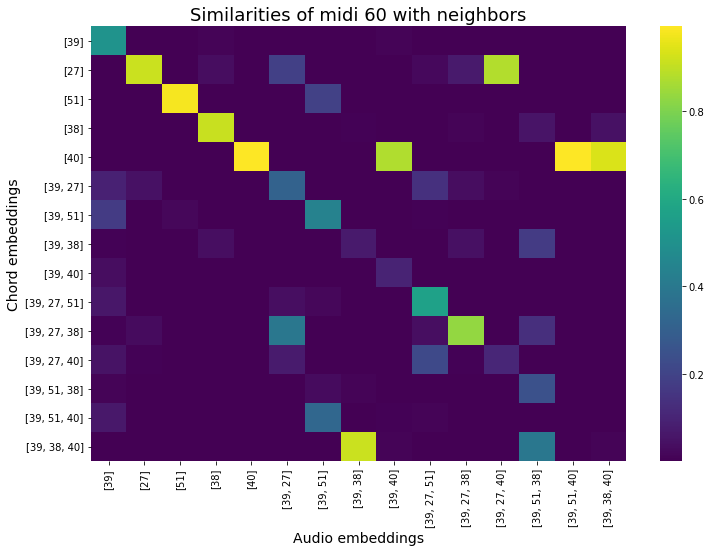

In [138]:
start_midi = 60 # middle C
c_and_neighbors_notes = note_and_neighbors(start_midi - min_midi)
plot_similarities(c_and_neighbors_notes, f'Similarities of midi {start_midi} with neighbors')

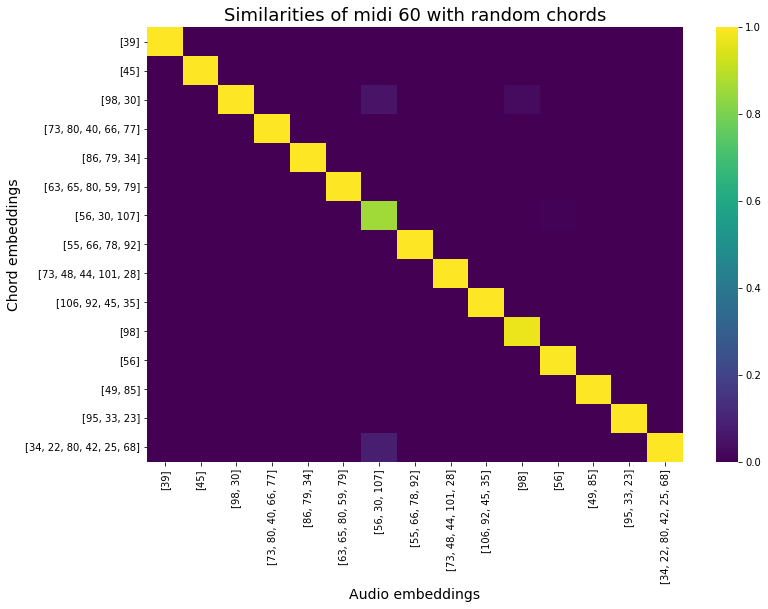

In [139]:
def random_chords(n):
    midi_span = max_midi - min_midi + 1
    c = []
    for _ in range(n):
        # num_notes = np.random.choice([1,2,3,4,5,6], p=[0.5, 0.25, 0.125, 0.0625, 0.03125, 0.03125])
        num_notes = np.random.choice([1,2,3,4,5,6])
        batch_midi_idxs = np.random.choice(midi_span, size=num_notes, p=midi_probs)
        c.append([m for m in midis[batch_midi_idxs] if m > 0])
    return c


start_midi = 60 # middle C
c_and_random_notes = [[start_midi - min_midi]] + random_chords(14)
plot_similarities(c_and_random_notes, f'Similarities of midi {start_midi} with random chords')

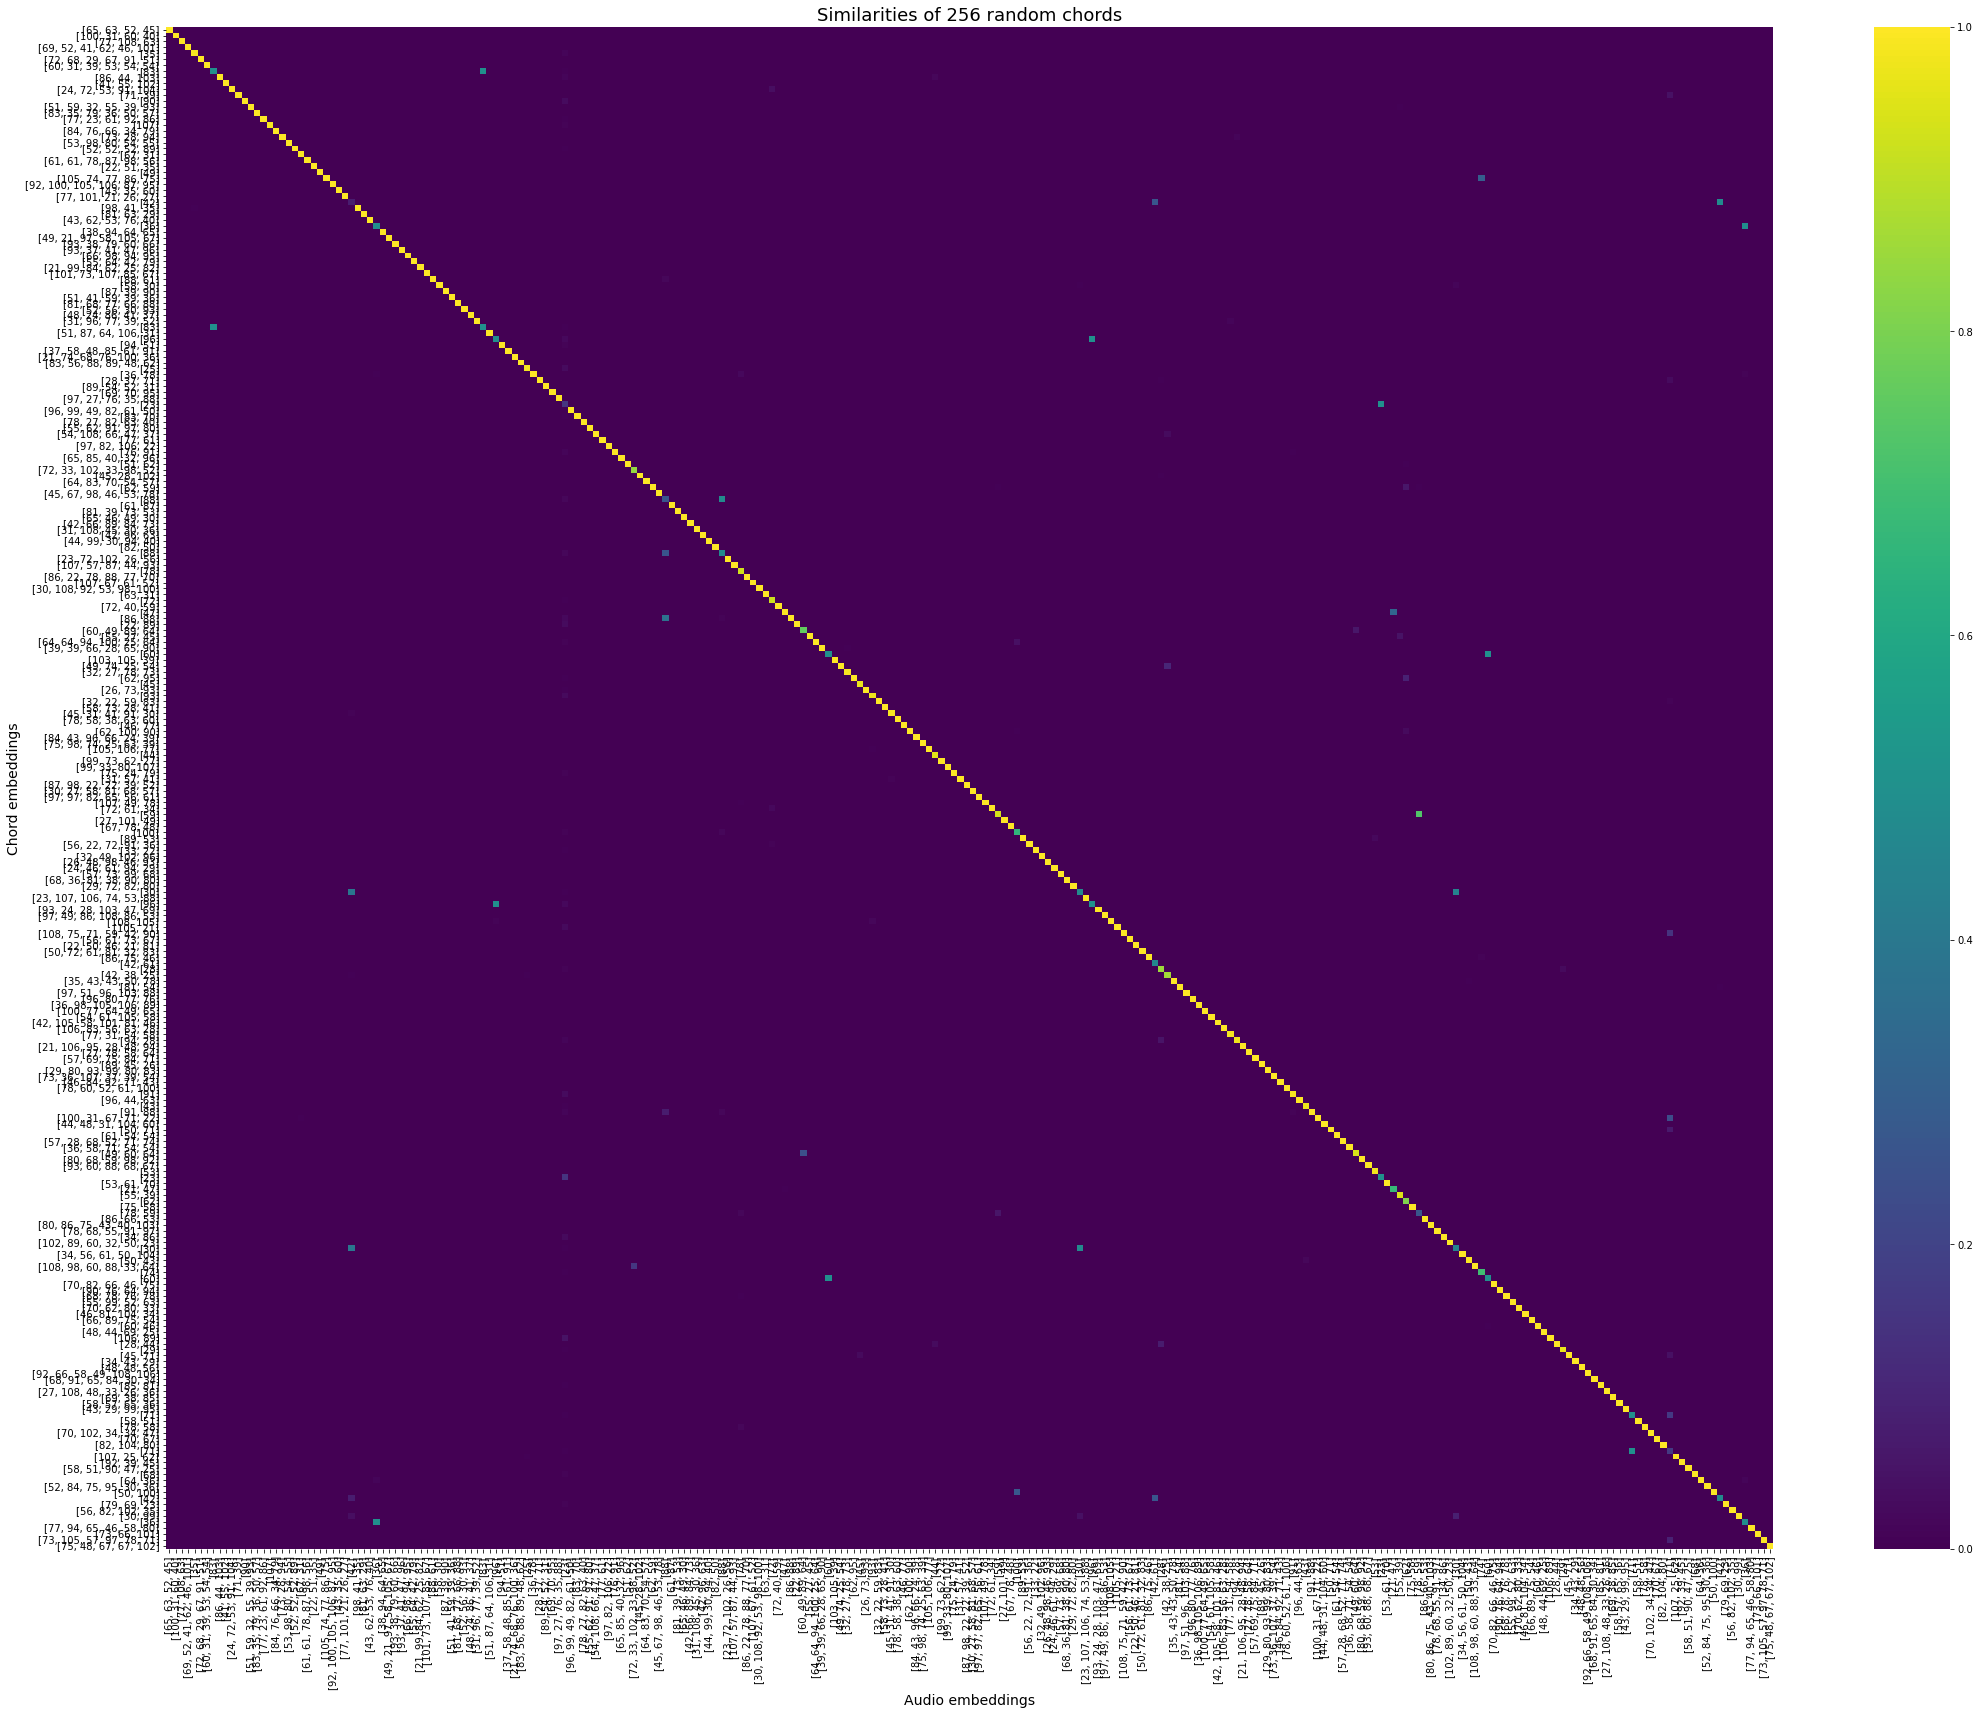

In [140]:
batch_of_random_notes = random_chords(256)
plot_similarities(batch_of_random_notes, f'Similarities of 256 random chords', figsize=(36,28))

got 157 neighbors of middle C


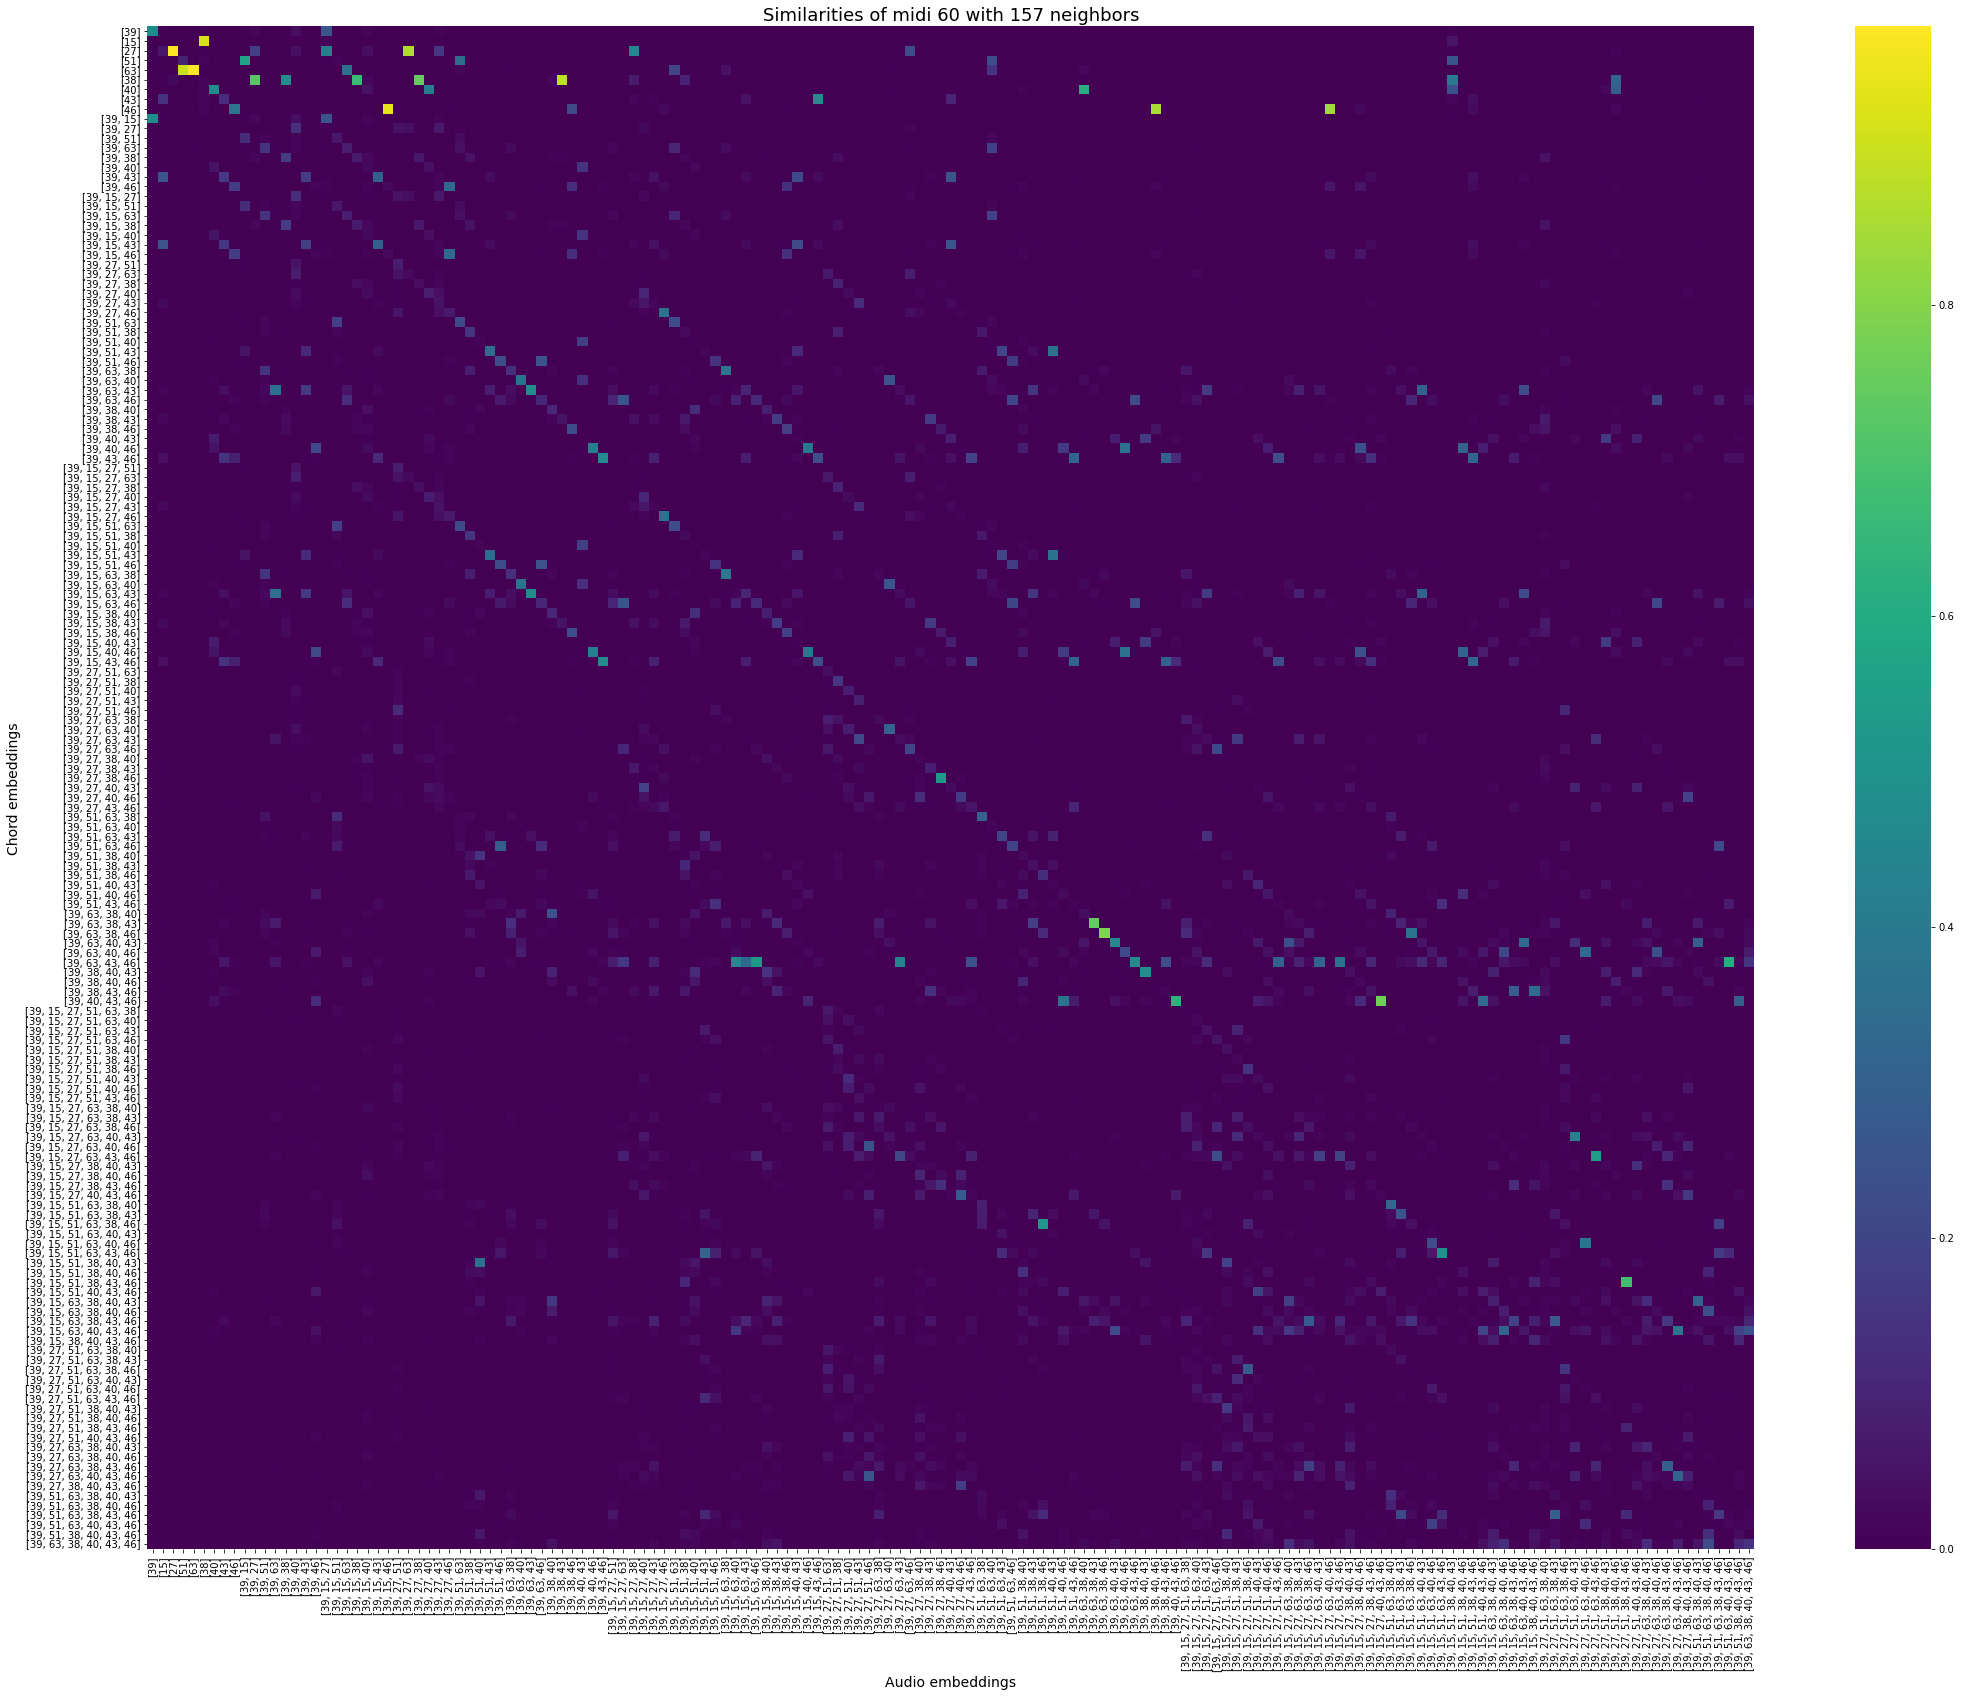

In [145]:
def note_and_neighbors_bigger(note_midi):
    neighbor_notes = [
        note_midi - 24, # two octaves down
        note_midi - 12, # octave down
        note_midi + 12, # octave up
        note_midi + 24, # two octaves up
        note_midi - 1, # note off-by-one
        note_midi + 1, # note off-by-one
        note_midi + 4, # major third
        note_midi + 7, # major fifth
    ]
    one_note_chords = [[note_midi]] + [[n] for n in neighbor_notes]
    two_note_chords = [[note_midi, n] for n in neighbor_notes]
    three_note_chords = [[note_midi] + list(chord) for chord in itertools.combinations(neighbor_notes, 2)]
    four_note_chords = [[note_midi] + list(chord) for chord in itertools.combinations(neighbor_notes, 3)]
    five_note_chords = [[note_midi] + list(chord) for chord in itertools.combinations(neighbor_notes, 4)]
    six_note_chords = [[note_midi] + list(chord) for chord in itertools.combinations(neighbor_notes, 5)]
    return one_note_chords + two_note_chords + three_note_chords + four_note_chords + six_note_chords

start_midi = 60 # middle C
c_and_more_neighbors = note_and_neighbors_bigger(start_midi-min_midi)
print(f'got {len(c_and_more_neighbors)} neighbors of middle C')
plot_similarities(c_and_more_neighbors, f'Similarities of midi {start_midi} with {len(c_and_more_neighbors)} neighbors', figsize=(36, 28))